In [115]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

# Loading the data

In [39]:
path_digit = "../Session 1/digits.npz"
path_pima = "./pima.npz"

with np.load(path_digit) as digits_data:
    img = (digits_data['x'] / 255).reshape(3000, 28 ,28)
    img_train = (digits_data['xt'] / 255).reshape(1500, 28 ,28)
    img_label = digits_data['y']
    img_train_label = digits_data['yt']
    
with np.load(path_pima) as pima_data:
#     print(pima_data.files)
    xall = pima_data['xall']
    yall = pima_data['yall']
    varnames = pima_data['varnames']

In [41]:
# compute statistics
pima_df = pd.DataFrame(xall, columns=varnames)
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,3.747532,121.607898,69.643159,20.765867,80.531735,32.453032,0.470961,33.021157
std,3.339502,30.490598,18.135582,15.899540,112.678399,6.950733,0.325256,11.669089
min,0.000000,44.000000,0.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.500000,0.243000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.374000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.600000,0.629000,40.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.420000,81.000000


First, we look at the statistics of the variables. 

- Pregnancies: The mean number of pregnancies is 3.75 . The minimum is 0 (the minimum age is 21 years, logical); the others quartiles also seems normal. But the maximum is 17 times, which seems a little big (potential outlier).
- Glucose, BMI, DiabetesPedigreeFunction: Mean and the quartiles seem reasonable.
- BloodPressure: The minimum seems being an outlier.
- SkinThickness, Insulin: same as BloodPressure, strange when we look at minimum and first quartile. Probably, there are missing data on those samples.
- Age: average age is 33 years old. The samples are relatively young. Need to pay attention to the maximum (81 years old).

In [14]:
def plots(imgs, interp=False):
    imgs=np.array(imgs)
    mn,mx=imgs.min(),imgs.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(imgs)):
        sp=f.add_subplot(1, len(imgs), i+1)
        plt.axis('off')
        plt.imshow(imgs[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

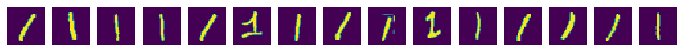

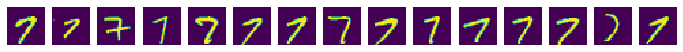

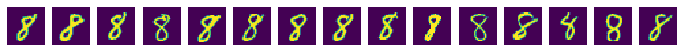

In [15]:
n_samples_per_class = int(img.shape[0] / 3)
n_sample_to_show = 15

plots(img[:15,:,:])
plots(img[n_samples_per_class:n_samples_per_class+n_sample_to_show,:,:])
plots(img[n_samples_per_class*2:n_samples_per_class*2+n_sample_to_show,:,:])

# Predicting Diabetes on the Pima dataset

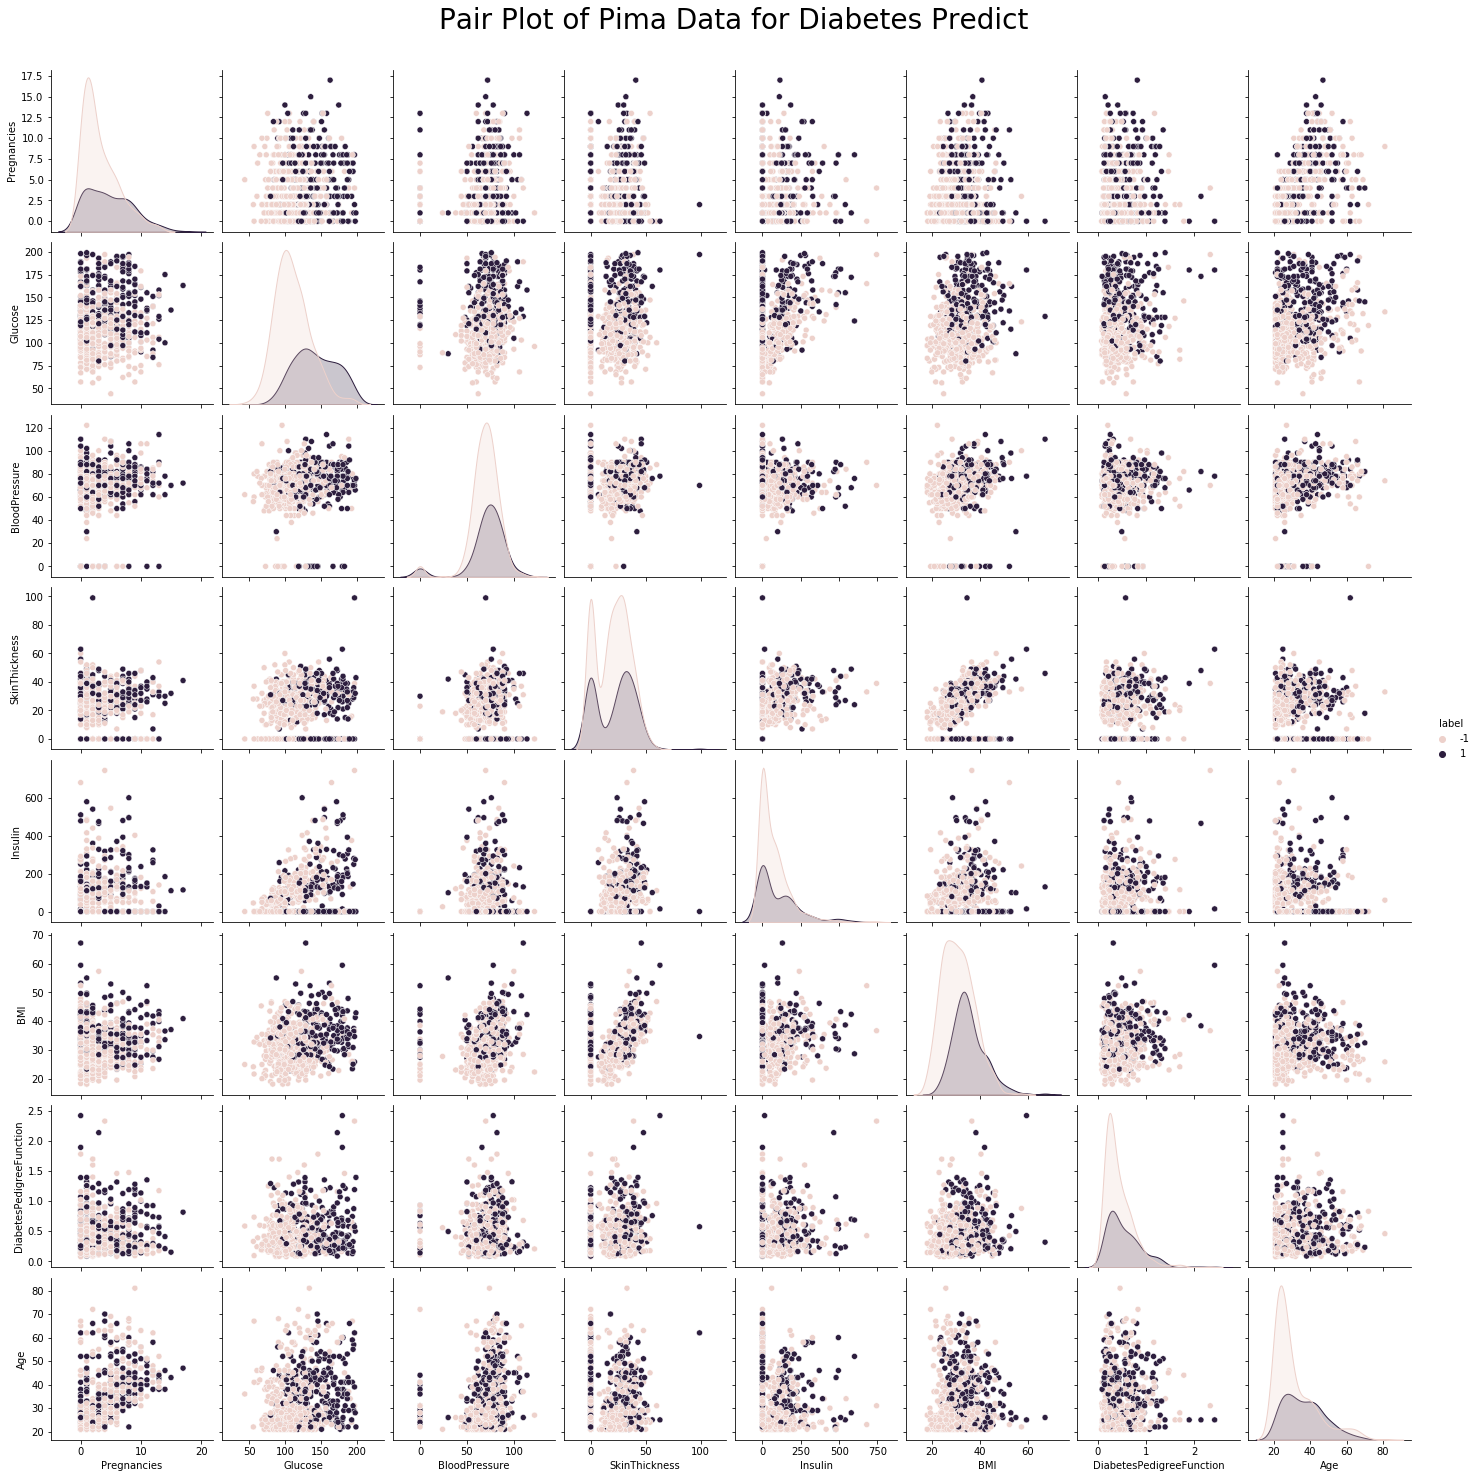

In [32]:
pima_df['label'] = yall
sns.pairplot(pima_df, hue='label')
plt.suptitle('Pair Plot of Pima Data for Diabetes Predict', 
             size = 28, y = 1.03)
plt.show()

Looking at the histogram of uni-variate, the ditribution of two classes in `BMI` and in `Glucose` are different (different position of picks for example). The pairplot between them is also discriminatory for two classes.

Therefore, these two variables seems to be good variables for prediction. Meanwhile, `BMI` and `Glucose` are strongly related to the diabetes. It does make sense to analyse them, from a medical perspective.

## Split data (shuffle)

In [42]:
pima_train_x, pima_test_x, pima_train_y, pima_test_y  = train_test_split(xall, yall, train_size=300, shuffle=True)

## Standard Scaler

The variance of variable `Glucose` is 30.5; but for `BMI`, the variance is 7.0

It could be a problem when we apply a linear model (the scale of parameters before these two variables could be largely different, which is not good for robustness of model)

As a result, it would be better to perform a standarization as a preprocessing.

In [43]:
scaler = StandardScaler()
pima_train_x = scaler.fit_transform(pima_train_x)
pima_test_x = scaler.transform(pima_test_x)

# Bayesian decision and linear classification

### LDA

In [62]:
lda = LinearDiscriminantAnalysis()
lda.fit(pima_train_x, pima_train_y)

print(f"The accuracy on test data is {lda.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, lda.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7897310513447433
The AUC score on test data is 0.8487969721546363


In [109]:
parameters = {'shrinkage': np.linspace(0, 1, 50)}
grid_search = GridSearchCV(LinearDiscriminantAnalysis(solver='eigen'), parameters, scoring='roc_auc')

grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=LinearDiscriminantAnalysis(solver='eigen'),
             param_grid={'shrinkage': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='roc_auc')

In [110]:
print(f"The best parameter is {grid_search.best_params_}, the best AUC score is {grid_search.best_score_}")

The best parameter is {'shrinkage': 0.04081632653061224}, the best AUC score is 0.829134023870866


### QDA

The optimal parameter is shrinkage=0.041. We found that the AUC socre is lower than before (without GridSearch).

In [112]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(pima_train_x, pima_train_y)

print(f"The accuracy on test data is {qda.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, qda.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7310513447432763
The AUC score on test data is 0.8014598540145985


The performance of QDA is worse than LDA. 

In [113]:
parameters = {'reg_param': np.linspace(0, 1, 50)}
grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), parameters, scoring='roc_auc')

grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=QuadraticDiscriminantAnalysis(),
             param_grid={'reg_param': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='roc_auc')

In [114]:
print(f"The best parameter is {grid_search.best_params_}, the best AUC score is {grid_search.best_score_}")

The best parameter is {'reg_param': 0.6326530612244897}, the best AUC score is 0.8257450152186994


The optimal parameter is reg_param=0.63. We found that the AUC socre is better than before (without GridSearch).

### Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(pima_train_x, pima_train_y)